https://www.kaggle.com/code/code1110/riiid-lgb-training-and-save-model

In [1]:
import os
import time
import itertools

from collections import OrderedDict, defaultdict
from abc import *

from datetime import datetime

import logging
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PATH = 'train_data.csv'
df = pd.read_csv(PATH)

In [3]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


In [4]:
shifted_df = df.copy()

shifted_df['answer_shift_-2'] = shifted_df.groupby('userID')['answerCode'].shift(-2)
shifted_df['answer_shift_-1'] = shifted_df.groupby('userID')['answerCode'].shift(-1)

shifted_df['answer_shift_1'] = shifted_df.groupby('userID')['answerCode'].shift(1)
shifted_df['answer_shift_2'] = shifted_df.groupby('userID')['answerCode'].shift(2)

shifted_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,answer_shift_-2,answer_shift_-1,answer_shift_1,answer_shift_2
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1.0,1.0,NaN,NaN
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1.0,1.0,NaN
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1.0,1.0,1.0,1.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1.0,1.0,1.0,1.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,1.0,1.0,0.0,1.0
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1.0,1.0,0.0,0.0
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,1.0,1.0,1.0,0.0
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,NaN,1.0,1.0,1.0


In [7]:
shifted_df['Timestamp'] = pd.to_datetime(shifted_df['Timestamp'])
shifted_df['Timestamp'].dtype

dtype('<M8[ns]')

In [10]:
shifted_df['solvedTime'] = shifted_df.groupby('userID')['Timestamp'].diff()

In [11]:
shifted_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,answer_shift_-2,answer_shift_-1,answer_shift_1,answer_shift_2,solvedTime
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1.0,1.0,NaN,NaN,NaT
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1.0,1.0,NaN,0 days 00:00:03
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1.0,1.0,1.0,1.0,0 days 00:00:08
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1.0,1.0,1.0,1.0,0 days 00:00:07
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,0.0,1.0,1.0,1.0,0 days 00:00:07
...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,1.0,1.0,0.0,1.0,0 days 00:00:24
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1.0,1.0,0.0,0.0,76 days 18:16:18
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,1.0,1.0,1.0,0.0,0 days 00:00:11
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,NaN,1.0,1.0,1.0,0 days 00:00:46


In [12]:
cumsum_df = shifted_df.copy()

cumsum_df['cumsumTime'] = cumsum_df.groupby('userID')['solvedTime'].cumsum()

cumsum_df[['userID', 'Timestamp', 'solvedTime', 'cumsumTime']]

,userID,Timestamp,solvedTime,cumsumTime
0,0,2020-03-24 00:17:11,NaT,NaT
1,0,2020-03-24 00:17:14,0 days 00:00:03,0 days 00:00:03
2,0,2020-03-24 00:17:22,0 days 00:00:08,0 days 00:00:11
3,0,2020-03-24 00:17:29,0 days 00:00:07,0 days 00:00:18
4,0,2020-03-24 00:17:36,0 days 00:00:07,0 days 00:00:25
...,...,...,...,...
2266581,7441,2020-06-05 06:50:21,0 days 00:00:24,0 days 00:03:40
2266582,7441,2020-08-21 01:06:39,76 days 18:16:18,76 days 18:19:58
2266583,7441,2020-08-21 01:06:50,0 days 00:00:11,76 days 18:20:09
2266584,7441,2020-08-21 01:07:36,0 days 00:00:46,76 days 18:20:55


In [13]:
correct_df = cumsum_df.copy()

correct_df['shift'] = correct_df.groupby('userID')['answerCode'].shift().fillna(0)
correct_df['past_correct'] = correct_df.groupby('userID')['shift'].cumsum()

correct_df[['userID','answerCode','past_correct']]

,userID,answerCode,past_correct
0,0,1,0.0
1,0,1,1.0
2,0,1,2.0
3,0,1,3.0
4,0,1,4.0
...,...,...,...
2266581,7441,0,1.0
2266582,7441,1,1.0
2266583,7441,1,2.0
2266584,7441,1,3.0


In [14]:
reversed_correct_df = correct_df.iloc[::-1].copy()

reversed_correct_df['shift'] = reversed_correct_df.groupby('userID')['answerCode'].shift().fillna(0)
reversed_correct_df['future_correct'] = reversed_correct_df.groupby('userID')['shift'].cumsum()
correct_df = reversed_correct_df.iloc[::-1]

correct_df[['userID','answerCode','future_correct']]

,userID,answerCode,future_correct
0,0,1,469.0
1,0,1,468.0
2,0,1,467.0
3,0,1,466.0
4,0,1,465.0
...,...,...,...
2266581,7441,0,4.0
2266582,7441,1,3.0
2266583,7441,1,2.0
2266584,7441,1,1.0


In [19]:
# 과거에 해당 문제를 맞춘 횟수
correct_df['shift'] = correct_df.groupby(['userID','assessmentItemID'])['answerCode'].shift().fillna(0)
correct_df['past_content_correct'] = correct_df.groupby(['userID','assessmentItemID'])['shift'].cumsum()

correct_df[['userID', 'assessmentItemID', 'answerCode', 'past_content_correct']]

,userID,assessmentItemID,answerCode,past_content_correct
0,0,A060001001,1,0.0
1,0,A060001002,1,0.0
2,0,A060001003,1,0.0
3,0,A060001004,1,0.0
4,0,A060001005,1,0.0
...,...,...,...,...
2266581,7441,A030071005,0,0.0
2266582,7441,A040165001,1,0.0
2266583,7441,A040165002,1,0.0
2266584,7441,A040165003,1,0.0


In [20]:
# 과거에 푼 문제 수
correct_df['past_count'] = correct_df.groupby('userID').cumcount()

correct_df[['userID', 'answerCode', 'past_count']]

,userID,answerCode,past_count
0,0,1,0
1,0,1,1
2,0,1,2
3,0,1,3
4,0,1,4
...,...,...,...
2266581,7441,0,4
2266582,7441,1,5
2266583,7441,1,6
2266584,7441,1,7


In [21]:
#과거 모든 문제에 대한 평균 정답률
correct_df['correct_ratio'] = (correct_df['past_correct']/correct_df['past_count']).fillna(0)

correct_df[['userID', 'answerCode', 'correct_ratio']]

,userID,answerCode,correct_ratio
0,0,1,0.000000
1,0,1,1.000000
2,0,1,1.000000
3,0,1,1.000000
4,0,1,1.000000
...,...,...,...
2266581,7441,0,0.250000
2266582,7441,1,0.200000
2266583,7441,1,0.333333
2266584,7441,1,0.428571


In [22]:
# 과거 해당 문제에 대한 평균 정답률

correct_df['past_content_count'] = correct_df.groupby(['userID', 'assessmentItemID']).cumcount()

correct_df['content_correct_ratio'] = (correct_df['past_content_correct']/correct_df['past_content_count']).fillna(0)

correct_df[['userID', 'answerCode', 'content_correct_ratio']]

,userID,answerCode,content_correct_ratio
0,0,1,0.0
1,0,1,0.0
2,0,1,0.0
3,0,1,0.0
4,0,1,0.0
...,...,...,...
2266581,7441,0,0.0
2266582,7441,1,0.0
2266583,7441,1,0.0
2266584,7441,1,0.0


In [32]:
correct_df['solvedTime'] = correct_df['solvedTime'].shift(-1)

AttributeError: 'TimedeltaProperties' object has no attribute 'second'

In [33]:
correct_df['time'] = correct_df['solvedTime'].dt.total_seconds()
correct_df['time']

0                3.0
1                8.0
2                7.0
3                7.0
4               11.0
             ...    
2266581    6632178.0
2266582         11.0
2266583         46.0
2266584         73.0
2266585          NaN
Name: time, Length: 2266586, dtype: float64

In [36]:
correct_df['mean_time'] = correct_df.groupby('userID')['time'].rolling(3).mean().values

correct_df[['userID', 'solvedTime', 'mean_time']]

,userID,solvedTime,mean_time
0,0,0 days 00:00:03,NaN
1,0,0 days 00:00:08,NaN
2,0,0 days 00:00:07,6.000000e+00
3,0,0 days 00:00:07,7.333333e+00
4,0,0 days 00:00:11,8.333333e+00
...,...,...,...
2266581,7441,76 days 18:16:18,2.210745e+06
2266582,7441,0 days 00:00:11,2.210738e+06
2266583,7441,0 days 00:00:46,2.210745e+06
2266584,7441,0 days 00:01:13,4.333333e+01


In [37]:
#아이디별 풀이 시간 전체 평균
agg_df = correct_df.copy()

median_df = agg_df.groupby('userID')['time'].agg(['median'])
agg_dict = median_df.to_dict()

agg_df['time_median'] = agg_df['userID'].map(agg_dict['median'])

agg_df[['userID', 'time', 'time_median']]

,userID,time,time_median
0,0,3.0,27.0
1,0,8.0,27.0
2,0,7.0,27.0
3,0,7.0,27.0
4,0,11.0,27.0
...,...,...,...
2266581,7441,6632178.0,43.0
2266582,7441,11.0,43.0
2266583,7441,46.0,43.0
2266584,7441,73.0,43.0


In [46]:
time_df = agg_df.copy()

#시간대
time_df['hour'] = time_df['Timestamp'].transform(lambda x: pd.to_datetime(x, unit='s').dt.hour)

In [48]:

#시간대별 정답률
hour_dict = time_df.groupby('hour')['answerCode'].mean().to_dict()
time_df['correct_per_hour'] = time_df['userID'].map(hour_dict)

In [49]:
#사용자 주 활동 시간 & 야행성 여부
time_df['hour_mode'] = time_df.groupby('userID')['hour'].agg(lambda x:pd.Series.mode(x)[0]).to_dict()
time_df['is_night'] = time_df['hour_mode']>12

In [50]:
time_df[['userID', 'hour', 'correct_per_hour', 'is_night']]

,userID,hour,correct_per_hour,is_night
0,0,0,0.649446,False
1,0,0,0.649446,True
2,0,0,0.649446,False
3,0,0,0.649446,False
4,0,0,0.649446,False
...,...,...,...,...
2266581,7441,6,NaN,False
2266582,7441,1,NaN,False
2266583,7441,1,NaN,False
2266584,7441,1,NaN,False


In [51]:
# 문제풀이 시간 정규화
time_df['normalized_time'] = time_df.groupby('userID')['time'].transform(lambda x: (x-x.mean())/x.std())


In [52]:
time_df['relative_time'] = time_df.groupby('userID').apply(lambda x:x['time']-x['time'].median()).values

In [53]:
# 문제를 풀이 시간 3단계 구간으로 나누기
time_df['time_cut'] = pd.cut(time_df['time'], bins=3)
time_df['time_qcut'] = pd.qcut(time_df['time'], q=3)

time_df[['time', 'time_cut', 'time_qcut']]

,time,time_cut,time_qcut
0,3.0,"(-25602.295, 8534098.333]","(-0.001, 19.0]"
1,8.0,"(-25602.295, 8534098.333]","(-0.001, 19.0]"
2,7.0,"(-25602.295, 8534098.333]","(-0.001, 19.0]"
3,7.0,"(-25602.295, 8534098.333]","(-0.001, 19.0]"
4,11.0,"(-25602.295, 8534098.333]","(-0.001, 19.0]"
...,...,...,...
2266581,6632178.0,"(-25602.295, 8534098.333]","(78.0, 25602295.0]"
2266582,11.0,"(-25602.295, 8534098.333]","(-0.001, 19.0]"
2266583,46.0,"(-25602.295, 8534098.333]","(19.0, 78.0]"
2266584,73.0,"(-25602.295, 8534098.333]","(19.0, 78.0]"


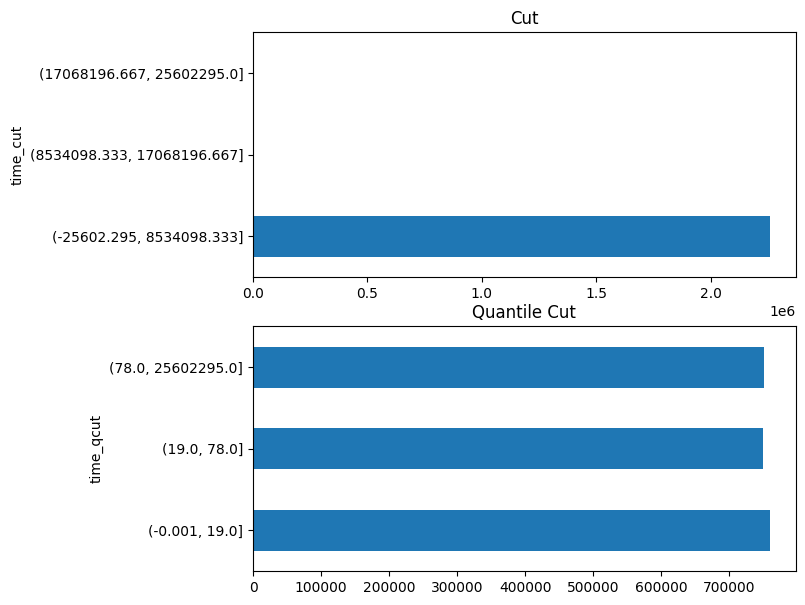

In [55]:
# 시각화
plt.figure(figsize=(7, 7))

plt.subplot(2, 1, 1)
plt.title('Cut')
time_df.groupby('time_cut').count().iloc[:, 0].plot(kind='barh');

plt.subplot(2, 1, 2)
plt.title('Quantile Cut')
time_df.groupby('time_qcut').count().iloc[:, 0].plot(kind='barh');

In [63]:
time_df[time_df['past_content_count']>1][['userID', 'assessmentItemID', 'past_content_count']]

,userID,assessmentItemID,past_content_count
127765,165,A090007001,2
127766,165,A090007002,2
127767,165,A090007003,2
127768,165,A090007004,2
127769,165,A090007005,2
...,...,...,...
1911697,3775,A020118001,2
1911698,3775,A020118002,2
1911699,3775,A020118003,2
1911700,3775,A020118004,2


In [64]:
834/time_df.shape[0]

0.00036795427131377324

In [65]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


In [82]:
correct_df = df.groupby(['userID', 'assessmentItemID']).answerCode.sum().reset_index()
pivot_df = correct_df.pivot(index='userID', columns = 'assessmentItemID', values = 'answerCode').fillna(0)

In [84]:
pivot_df

assessmentItemID,A010001001,A010001002,A010001003,A010001004,A010001005,A010002001,A010002002,A010002003,A010002004,A010002005,...,A090073003,A090073004,A090073005,A090073006,A090074001,A090074002,A090074003,A090074004,A090074005,A090074006
userID,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


이전까지 코드만 보기

In [85]:
from numpy.linalg import svd

U, sigma, VT = svd(pivot_df)

U, np.diag(sigma), VT

(array([[-1.30147792e-002, -7.44607320e-003,  1.45956731e-002, ...,
         -8.73741701e-006,  1.07408547e-004,  2.47032823e-323],
        [-1.74807700e-002, -1.05430582e-002,  1.35401418e-002, ...,
          1.61946466e-003,  4.49070660e-004, -3.73401025e-018],
        [-6.30842607e-003, -6.14955022e-003,  1.23905140e-002, ...,
         -3.89043241e-004,  8.96820640e-004,  1.88157929e-018],
        ...,
        [-2.42605071e-004, -1.31596940e-004,  1.58953581e-004, ...,
         -2.97415429e-002,  2.22352178e-002,  1.44144165e-017],
        [-1.81752890e-004, -1.19151694e-004,  3.01466654e-004, ...,
          1.28969605e-002,  1.60108448e-002, -1.70093456e-017],
        [-9.74734575e-005, -5.52965411e-005,  1.02794075e-004, ...,
          7.56408388e-002,  1.43298011e-002, -2.29579269e-018]]),
 array([[2.99209638e+02, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.33817602e+02, 0.00000000e+00, ...,
         0.

In [ ]:
# 차원 축소한 결과의 설명력
sigma[:].sum()

In [99]:
# 유저와 문제의 값 종류
users = pivot_df.index.values
contents = pivot_df.columns.values

# 유저 잠재 요인 - U
user_latent_factor = {}

# scaling
U = U @ np.diag(sigma)

for i, user in enumerate(users):
    user_latent_factor[user] = U[i]
    #print(f'user {user} latent factor {U[i]}')

# 문제 잠재 요인 - V
content_latent_factor = {}

# scaling
VT = np.concatenate((np.diag(sigma), np.zeros((6698, 9454-6698))), axis=1) @ VT

for i, content in enumerate(contents):
    content_latent_factor[content] = VT.T[i]
    #bprint(f'content {content} latent factor {VT.T[i]}')

In [100]:
nested_content_df = df['assessmentItemID'].map(content_latent_factor).values
content_If = np.concatenate(nested_content_df, 0).reshape(-1,9454)
time_df[[f'content_If{i+1}' for i in range(9454)]] = content_If
time_df[['content_If1','content_If2','content_If3']]

MemoryError: Unable to allocate 113. GiB for an array with shape (15181593028,) and data type float64